In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Base Decision Class

In [2]:
class BaseDecisionMaker:
    def __init__(self, rewardDictionary, meritVector, beta, numberOfAgents):
        self.rewardDictionary = rewardDictionary
        self.merit = meritVector
        self.beta = beta
        self.numberOfAgents = numberOfAgents
        
    def __call__(self, alphaVector):
        expectedReward = self.getExpectedRewardForDecisionMaker()
        utilityOfEfficiency = self.getUtilityOfEfficiency(expectedReward, alphaVector[0])
        utilityOfInequity = self.getUtilityOfInequity(expectedReward, alphaVector[1])
        baseUtility = self.getBaseDecisionUtility(utilityOfEfficiency, utilityOfInequity)  
        return(baseUtility)
        
    def getExpectedRewardForDecisionMaker(self):  # verb for function names
        dic = dict()  # name of variables
        for action in self.rewardDictionary.keys():
            expectedReward = [0] * self.numberOfAgents
            for rewardScheme in self.rewardDictionary[action].keys():
                probability = self.rewardDictionary[action][rewardScheme]
                for i in range(0, len(rewardScheme)):
                    expectedReward[i] = expectedReward[i] + probability * rewardScheme[i]
            dic[action] = expectedReward
        return dic
    
    def getUtilityOfEfficiency(self, expectedReward, agentWeights): 
        dic = dict()
        actions = list(self.rewardDictionary.keys()) 
        for i in range(0, len(actions)):
            rewardForActioni = expectedReward[actions[i]]
            totalReward = sum([agentWeights[k] * rewardForActioni[k] for k in
                               range(0, len(agentWeights))])
            dic[actions[i]] = totalReward
        return dic 
    
    def getInequityForAction(self, reward):
        inequitySum = 0
        for i in range(0, len(reward)):
            for j in range(i + 1, len(self.merit)):
                inequitySum = inequitySum + abs(reward[i] * self.merit[j] - reward[j] * self.merit[i])
        return inequitySum
    
    def getUtilityOfInequity(self, expectedReward, weightForInequity):
        actions = list(self.rewardDictionary.keys())  # ['A', 'B', 'C']
        totalInequity = [self.getInequityForAction(expectedReward[action]) for action in actions]
        weightedTotalInequityDic = {actions[i]: totalInequity[i] * weightForInequity for i in range(0, len(actions))}
        return (weightedTotalInequityDic) 
    
    def getBaseDecisionUtility(self, utilityOfEfficiencyDict, utilityOfInequityDict):
        baseDecisionUtilitydic = {action: utilityOfEfficiencyDict[action] - utilityOfInequityDict[action] for action in
                                  utilityOfEfficiencyDict.keys()}
        return baseDecisionUtilitydic 
    
    

def getActionProbabilityGivenAlpha(baseUtility, beta):
    weightedUtility = {action: math.exp(baseUtility[action] * beta) for action in baseUtility.keys()}
    sumOfWeightedUtility = sum([weightedUtility[action] for action in baseUtility.keys()])
    expDistribution = {action: weightedUtility[action] / sumOfWeightedUtility for action in baseUtility.keys()}
    
    return expDistribution

# Part 2 Judge

In [3]:
def createTupleWithAlpha(alphaPartial, numberOfAgents, partialAgent):
    value = [alphaPartial] * numberOfAgents
    value[partialAgent] = -alphaPartial
    return tuple(value)

class JudgePartiality:
    def __init__(self, alphaPartial, numberOfAgents, alphaAI, beta, judgePrior):
       
        self.alphaPartial = alphaPartial
        self.numberOfAgents = numberOfAgents
        self.alphaAI = alphaAI
        self.beta = beta
        self.judgePrior = judgePrior
                   
    def __call__(self, getActionExpectedUtilityFunc):
        
        alphaVectorSet = self.getAlphaVectorSet(alphaPartial, numberOfAgents)
        
        baseActionProbGivenAlpha = self.getBaseActionProbGivenAlpha(alphaVectorSet, self.alphaAI, self.beta, getActionExpectedUtilityFunc)

        #partial:
        probOfAlphaGivenPartial = self.getProbOfAlphaGivenPartial(self.alphaPartial, alphaVectorSet, self.numberOfAgents)
        probOfAlpha_Partial = self.getProbOfAlpha(self.judgePrior, probOfAlphaGivenPartial)
        probOfPartial_alphaGivenAction = self.getProbOfPartialAndAlphaGivenAction(probOfAlpha_Partial, baseActionProbGivenAlpha)  
        
        # impartial condition
        probOfAlphaGivenImpartial = self.getProbOfAlphaGivenImpartial(alphaVectorSet)
        probOfAlpha_Impartial = self.getProbOfAlpha(self.judgePrior, probOfAlphaGivenImpartial)
        probOfImpartial_alphaGivenAction = self.getProbOfPartialAndAlphaGivenAction(probOfAlpha_Impartial, baseActionProbGivenAlpha)  
                    
        probOfPartial = self.getNormalizedProbOfPartial_alphaGivenAction(probOfPartial_alphaGivenAction,probOfImpartial_alphaGivenAction)
        return probOfPartial


    def getAlphaVectorSet(self,alphaPartial, numberOfAgents):
        alphaVector = [createTupleWithAlpha(alphaPartial, numberOfAgents, partialAgent) for partialAgent in range(numberOfAgents)]
        alphaVector.append((1,)* numberOfAgents)
        return alphaVector

    def getBaseActionProbGivenAlpha(self,alphaVectorSet, alphaAI, beta, getUtilityFunc):
        return {weight: getActionProbabilityGivenAlpha(getUtilityFunc([weight, alphaAI]),beta) for weight in alphaVectorSet}

    # partial condition
    def getProbOfAlphaGivenPartial (self,alphaPartial, alphaVectorSet, numberOfAgents):
        probOfAlphaGivenPartial = {alphaVector: 1.0/numberOfAgents for alphaVector in alphaVectorSet}
        probOfAlphaGivenPartial[(1,)*numberOfAgents] = 0
        return probOfAlphaGivenPartial

    def getProbOfAlpha(self,priorOfPartiality, probOfAlphaGivenPartiality):
        probOfAlpha = {alphaVector: probOfAlphaGivenPartiality[alphaVector]* priorOfPartiality for alphaVector in probOfAlphaGivenPartiality.keys()}
        return probOfAlpha

    def getProbOfPartialAndAlphaGivenAction(self, probOfAlpha, baseActionProbGivenAlpha):
        actionList = baseActionProbGivenAlpha.values()[1].keys()
        prob = {action:{weight: baseActionProbGivenAlpha[weight][action]*prob for (weight,prob) in zip(baseActionProbGivenAlpha.keys(),probOfAlpha.values())} for action in actionList}
        return prob

    # impartial
    def getProbOfAlphaGivenImpartial (self, alphaVectorSet):
        probOfAlphaGivenImpartial = {alphaVector: 0 for alphaVector in alphaVectorSet}
        probOfAlphaGivenImpartial[(1,)*numberOfAgents] = 1
        return probOfAlphaGivenImpartial
    
    def getNormalizedProbOfPartial_alphaGivenAction(self, probOfPartial_alphaGivenAction, probOfImpartial_alphaGivenAction):
        sumOfProbOfPartialGivenAction = [sum(list(probOfPartial_alphaGivenAction.values())[index].values()) for index in
                                     range(len(probOfPartial_alphaGivenAction.keys()))]
        sumOfProbOfImpartialGivenAction = [sum(list(probOfImpartial_alphaGivenAction.values())[index].values()) for index in
                                       range(len(probOfImpartial_alphaGivenAction.keys()))]
        sumOfProb = [probOfPartial + probOfImpartial for probOfPartial, probOfImpartial in
                 zip(sumOfProbOfPartialGivenAction, sumOfProbOfImpartialGivenAction)]
        probOfPartialGivenAction = {action: (partialProb/ sum) for (action,partialProb, sum) in zip(probOfPartial_alphaGivenAction.keys(),
                                                                            sumOfProbOfPartialGivenAction, sumOfProb)}
        return probOfPartialGivenAction



# Part3: Constructed Social Utility

In [4]:
def getConstructedUtility(alphaAI, probOfPartial, alphaPA, baseUtility):
    constructedUtilityDict = {action: baseUtility[action] - alphaPA * probOfPartial[action] for action in probOfPartial.keys()}
    return constructedUtilityDict

In [5]:
# helper function
def createProbDicList(highBonus, lowBonus, equalBonusList):
    dic = [{ "Action1": {(highBonus, lowBonus): 1}, "Action2": {(lowBonus, highBonus): 1}, "Action3": {(bonus, bonus): 1}} for bonus in equalBonusList]
    return dic

# Experiment

In [6]:
lambdaInput = 0.7
alphaAIList = [np.random.exponential(lambdaInput) for i in range(10000)]


In [7]:
absoluteEffort = 1
# alphaAI = 0.7 # mean of the exponential function, generate in prior with np.random.exponential(.7)


In [8]:
numberOfAgents = 2
beta = 0.003
alphaPartial = 6
alphaPA = 1350
judgePrior = 0.5
effort = [absoluteEffort, absoluteEffort]

equalBonus = np.linspace(0,1200, 50)
#equalBonus = [0, 200, 400, 600, 800, 1000, 1200]


probDicList = createProbDicList(1000, 100, equalBonus)

getActionExpectedUtilityGivenWeight = [BaseDecisionMaker(probabDict, effort, beta, numberOfAgents) 
                                       for probabDict in probDicList]

## Result of Figure 1-d, base decision maker P(equal bonus)

In [9]:
weightImpartial = [1, 1]

baseUtilityDict = [[getUtilityFunc([weightImpartial, alphaAI]) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAI in alphaAIList]
fullActionProb = [[getActionProbabilityGivenAlpha (utility, beta) for utility in baseUtilityDict[i]] for i in range(len(alphaAIList))]
equalBonusProb = [[fullActionProb[alphaAICase][index]["Action3"] for index in range(len(fullActionProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]


equalBonusProb_Summarized = [sum([sublist[i] for sublist in equalBonusProb]) / len(alphaAIList) for i in range(len(equalBonus))]

# Result of Figure 1-d, partiality

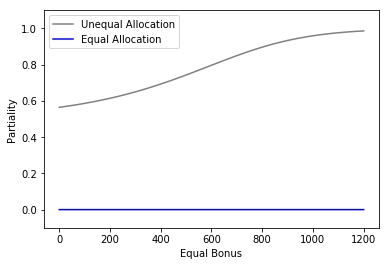

In [10]:
getJudgePartiality = [JudgePartiality (alphaPartial, numberOfAgents, alphaAI, beta, judgePrior) for alphaAI in alphaAIList]

probOfPartial_total = [[getJudgePartiality[alphaAICase](getUtilityFunc) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAICase in range(len(alphaAIList))] 

probOfPartial_unequalBonus = [[probOfPartial_total[alphaAICase][index]["Action1"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]
probOfPartial_equalBonus = [[probOfPartial_total[alphaAICase][index]["Action3"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]

probOfPartial_unequalBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_unequalBonus]) / len(alphaAIList) for i in range(len(equalBonus))]
probOfPartial_equalBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_equalBonus]) / len(alphaAIList) for i in range(len(equalBonus))]


plt.plot(equalBonus, probOfPartial_unequalBonus_Summarized, color='grey', label = 'Unequal Allocation')
plt.plot(equalBonus, probOfPartial_equalBonus_Summarized, color='blue', label = 'Equal Allocation')
plt.legend(loc='upper left')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.ylim(-0.1,1.1)
plt.show()

# Result of Figure 1-d, Constructed Social Utility

### AlphaVector = [1,1]

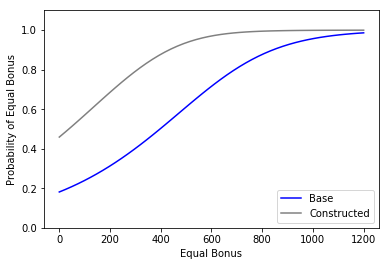

In [11]:
constructUtility = [[getConstructedUtility (alphaAIList[alphaAICase], probOfPartial, alphaPA, utiDict) for probOfPartial, utiDict in zip(probOfPartial_total[alphaAICase], baseUtilityDict[alphaAICase])] for alphaAICase in range(len(alphaAIList))]

fullConstructedProb = [[getActionProbabilityGivenAlpha (constUtility, beta) for constUtility in constructUtility[alphaAICase]] for alphaAICase in range(len(alphaAIList))]

equalBonusConstructedProb = [[fullConstructedProb[alphaAICase][index]["Action3"] for index in range(len(fullConstructedProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
equalBonusConstructedProb_Summarized = [sum([sublist[i] for sublist in equalBonusConstructedProb]) / len(alphaAIList) for i in range(len(equalBonus))]


plt.plot(equalBonus, equalBonusProb_Summarized, color='blue', label = 'Base')
plt.plot(equalBonus, equalBonusConstructedProb_Summarized, color='grey', label = 'Constructed')
plt.legend(loc='lower right')
plt.ylabel("Probability of Equal Bonus")
plt.xlabel("Equal Bonus")
plt.ylim(0,1.1)
plt.show()

# Figure2: 

In [12]:
numberOfAgents = 2
beta = 0.003
alphaPartial = 6
alphaPA = 1350
judgePrior = 0.5
effort = [absoluteEffort, absoluteEffort]

equalBonus = [0, 100, 500, 1000, 1100]
weightImpartial = [1, 1]

probDicList = createProbDicList(1000, 100, equalBonus)
getActionExpectedUtilityGivenWeight = [BaseDecisionMaker(probabDict, effort, beta, numberOfAgents) for probabDict in probDicList]

In [13]:
weightImpartial = [1, 1]
baseUtilityDict = [[getUtilityFunc([weightImpartial, alphaAI]) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAI in alphaAIList]

# partiality
getJudgePartiality = [JudgePartiality (alphaPartial, numberOfAgents, alphaAI, beta, judgePrior) for alphaAI in alphaAIList]
probOfPartial_total = [[getJudgePartiality[alphaAICase](getUtilityFunc) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAICase in range(len(alphaAIList))] 

probOfPartial_unequalBonus = [[probOfPartial_total[alphaAICase][index]["Action1"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]
probOfPartial_equalBonus = [[probOfPartial_total[alphaAICase][index]["Action3"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]

probOfPartial_unequalBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_unequalBonus]) / len(alphaAIList) for i in range(len(equalBonus))]
probOfPartial_equalBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_equalBonus]) / len(alphaAIList) for i in range(len(equalBonus))]

#constructed
constructUtility = [[getConstructedUtility (alphaAIList[alphaAICase], probOfPartial, alphaPA, utiDict) for probOfPartial, utiDict in zip(probOfPartial_total[alphaAICase], baseUtilityDict[alphaAICase])] for alphaAICase in range(len(alphaAIList))]

fullConstructedProb = [[getActionProbabilityGivenAlpha (constUtility, beta) for constUtility in constructUtility[alphaAICase]] for alphaAICase in range(len(alphaAIList))]

equalBonusConstructedProb = [[fullConstructedProb[alphaAICase][index]["Action3"] for index in range(len(fullConstructedProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
equalBonusConstructedProb_Summarized = [sum([sublist[i] for sublist in equalBonusConstructedProb]) / len(alphaAIList) for i in range(len(equalBonus))]

fairBonusConstructedProb = [[fullConstructedProb[alphaAICase][index]["Action1"] for index in range(len(fullConstructedProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
fairBonusConstructedProb_Summarized = [sum([sublist[i] for sublist in fairBonusConstructedProb]) / len(alphaAIList) for i in range(len(equalBonus))]



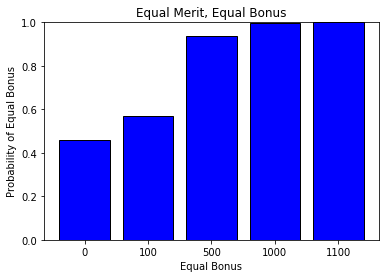

In [14]:
plt.bar([str(bonus) for bonus in equalBonus], equalBonusConstructedProb_Summarized,color='blue',edgecolor='black')
plt.ylabel("Probability of Equal Bonus")
plt.xlabel("Equal Bonus")
plt.title("Equal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

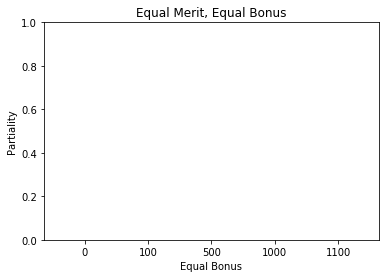

In [15]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_equalBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Equal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

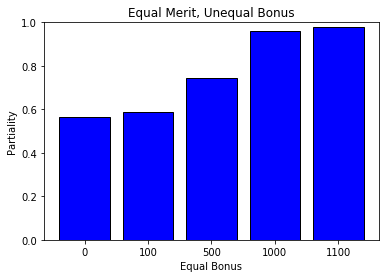

In [16]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_unequalBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Equal Merit, Unequal Bonus")
plt.ylim((0, 1)) 
plt.show()

# Figure 3
## Different Merit Condition: gamma1/ gamma2 = 4



In [17]:
absoluteEffort = 1

In [18]:
numberOfAgents = 2
beta = 0.003
alphaPartial = 6
alphaPA = 1350
judgePrior = 0.5

effort = [4*absoluteEffort, absoluteEffort]

equalBonus = [0, 100, 500, 1000, 1100]
probDicList = createProbDicList(1000, 100, equalBonus)

getActionExpectedUtilityGivenWeight = [BaseDecisionMaker(probabDict, effort, beta, numberOfAgents) 
                                       for probabDict in probDicList]


In [19]:
# base
weightImpartial = [1, 1]
baseUtilityDict = [[getUtilityFunc([weightImpartial, alphaAI]) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAI in alphaAIList]

# partiality
getJudgePartiality = [JudgePartiality (alphaPartial, numberOfAgents, alphaAI, beta, judgePrior) for alphaAI in alphaAIList]
probOfPartial_total = [[getJudgePartiality[alphaAICase](getUtilityFunc) for getUtilityFunc in getActionExpectedUtilityGivenWeight] for alphaAICase in range(len(alphaAIList))] 

probOfPartial_fairBonus = [[probOfPartial_total[alphaAICase][index]["Action1"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]
probOfPartial_unfairBonus = [[probOfPartial_total[alphaAICase][index]["Action2"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]
probOfPartial_equalBonus = [[probOfPartial_total[alphaAICase][index]["Action3"] for index in range(len(probOfPartial_total[alphaAICase]))]for alphaAICase in range(len(alphaAIList))]

probOfPartial_fairBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_fairBonus]) / len(alphaAIList) for i in range(len(equalBonus))]
probOfPartial_unfairBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_unfairBonus]) / len(alphaAIList) for i in range(len(equalBonus))]
probOfPartial_equalBonus_Summarized = [sum([sublist[i] for sublist in probOfPartial_equalBonus]) / len(alphaAIList) for i in range(len(equalBonus))]


#constructed
constructUtility = [[getConstructedUtility (alphaAIList[alphaAICase], probOfPartial, alphaPA, utiDict) for probOfPartial, utiDict in zip(probOfPartial_total[alphaAICase], baseUtilityDict[alphaAICase])] for alphaAICase in range(len(alphaAIList))]

fullConstructedProb = [[getActionProbabilityGivenAlpha (constUtility, beta) for constUtility in constructUtility[alphaAICase]] for alphaAICase in range(len(alphaAIList))]

equalBonusConstructedProb = [[fullConstructedProb[alphaAICase][index]["Action3"] for index in range(len(fullConstructedProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
equalBonusConstructedProb_Summarized = [sum([sublist[i] for sublist in equalBonusConstructedProb]) / len(alphaAIList) for i in range(len(equalBonus))]

fairBonusConstructedProb = [[fullConstructedProb[alphaAICase][index]["Action1"] for index in range(len(fullConstructedProb[alphaAICase]))] for alphaAICase in range(len(alphaAIList))]
fairBonusConstructedProb_Summarized = [sum([sublist[i] for sublist in fairBonusConstructedProb]) / len(alphaAIList) for i in range(len(equalBonus))]




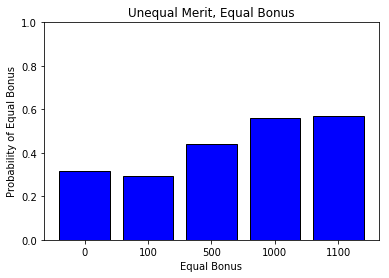

In [20]:
plt.bar([str(bonus) for bonus in equalBonus], equalBonusConstructedProb_Summarized,color='blue',edgecolor='black')
plt.ylabel("Probability of Equal Bonus")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

### Action 1: Fair Bonus

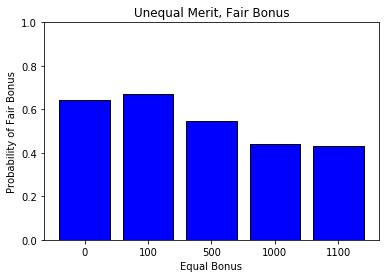

In [21]:
plt.bar([str(bonus) for bonus in equalBonus], fairBonusConstructedProb_Summarized,color='blue',edgecolor='black')
plt.ylabel("Probability of Fair Bonus")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Fair Bonus")
plt.ylim((0, 1)) 
plt.show()

## Partiality

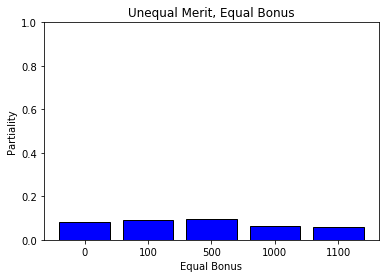

In [22]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_equalBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Equal Bonus")
plt.ylim((0, 1)) 
plt.show()

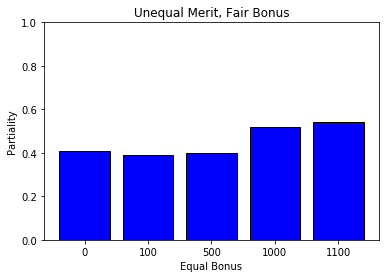

In [23]:
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_fairBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Fair Bonus")
plt.ylim((0, 1)) 
plt.show()

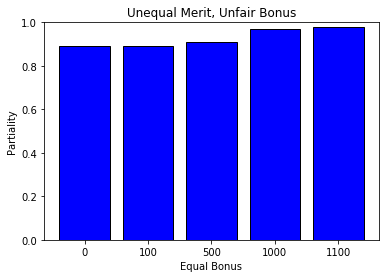

In [24]:
# Action 2 is the unfair allocation
plt.bar([str(bonus) for bonus in equalBonus], probOfPartial_unfairBonus_Summarized,color='blue',edgecolor='black')
plt.ylabel("Partiality")
plt.xlabel("Equal Bonus")
plt.title("Unequal Merit, Unfair Bonus")
plt.ylim((0, 1)) 
plt.show()